In [ ]:
class SongPairDataset(Dataset):
    def __init__(self, root_dir, batches, strategies, target_length=22050*10):
        self.root_dir = root_dir
        self.target_length = target_length
        self.batch_folders = [os.path.join(root_dir, f'batch_{i}') for i in batches]
        self.strategies = strategies
        self.batches = batches  # Store batches to retrieve correct strategy_id

        return songs, torch.tensor(labels), torch.tensor(strategy_id), pair_folders


class CrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads=4)

    def forward(self, query, key):

        return attn_output

class HAWithStrategy(nn.Module):
    def __init__(self, num_strategies, embedding_dim=128):

    def forward(self, songs, strategy_ids):
        print('\n----------------------------------')
        print('strategy_ids', strategy_ids)
        batch_size = len(songs)
        # strategy_embeddings = self.strategy_embedding(strategy_ids).unsqueeze(-1)
        # print('strategy embed shape', strategy_embeddings.shape)


        # actually mel not stft
        waveform_features_list_1 = []
        stft_features_list_1 = []
        waveform_features_list_2 = []
        stft_features_list_2 = []

        added_1 = []
        added_2 = []

        for song1_waveform, song2_waveform, song1_stft, song2_stft in songs:
            strategy_one_hot_init = F.one_hot(strategy_ids, num_classes=4).float()
            strategy_one_hot_wbranch = strategy_one_hot_init.view(1, 4, 1)
            strategy_one_hot_wbranch = strategy_one_hot_wbranch.expand(1, 4, 220500)
            song1_waveform = torch.cat((strategy_one_hot_wbranch, song1_waveform), dim=1)
            song2_waveform = torch.cat((strategy_one_hot_wbranch, song2_waveform), dim=1)

            # print('song1_stft beforn branch shape',song1_stft.shape)

            song1_waveform_features = self.waveform_branch(song1_waveform)
            song2_waveform_features = self.waveform_branch(song2_waveform)

            strategy_one_hot_fbranch = strategy_one_hot_init.view(1, 4, 1, 1)
            strategy_one_hot_fbranch = strategy_one_hot_fbranch.expand(1, 4, 128, 54)
            song1_stft = torch.cat((strategy_one_hot_fbranch, song1_stft), dim=1)
            song2_stft = torch.cat((strategy_one_hot_fbranch, song2_stft), dim=1)

            song1_stft_features = self.stft_branch(song1_stft.to(device))
            song2_stft_features = self.stft_branch(song2_stft.to(device))

            song1_features = self.cross_attention(song1_waveform_features,song1_stft_features)
            song2_features = self.cross_attention(song2_waveform_features,song2_stft_features)

            added_1.append(song1_features)
            added_2.append(song2_features)

        song1_features = torch.cat(added_1, dim=0)
        song2_features = torch.cat(added_2, dim=0)

        # print('song 1 features before cat', song1_features.shape)
        # print('song 2 features before cat', song2_features.shape)

        strategy_one_hot = F.one_hot(strategy_ids, num_classes=4).float()
        strategy_one_hot = strategy_one_hot.view(1, 4, 1, 1)  # Shape: [1, 4, 1, 1]
        strategy_one_hot = strategy_one_hot.expand(5, 4, 64, 27)  # Shape: [5, 4, 128, 54]

        combined_features = torch.cat((song1_features, song2_features, strategy_one_hot), dim=1)

        combined_features = self.channel_attention(combined_features)

        combined_features = self.combined_cnn(combined_features)

        combined_features = combined_features.view(combined_features.size(0), -1)
        output = self.fc(combined_features)

        return output

def listMLE(y_pred, y_true):

    eps = 1e-10

    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]
    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)
    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)
    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values
    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])
    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    return torch.mean(torch.sum(observation_loss, dim=1))



from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def train_model(model, train_dataloader, val_dataloader, epochs=500, start_epoch=0):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    batch_losses = []
    batch_correlations = []

    train_losses = []
    train_correlations = []
    val_losses = []
    val_correlations = []

    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss = 0
        epoch_correlation = 0

        for batch_idx, (songs, labels, strategy_ids, folder) in enumerate(train_dataloader):
            labels = labels.to(device).view(-1)
            strategy_ids = strategy_ids.to(device)

            optimizer.zero_grad()
            outputs = model(songs, strategy_ids).view(-1)
            loss = listMLE(outputs.unsqueeze(0), labels.unsqueeze(0))

            # threshold_low = 3.5
            # threshold_high = 4.5
            threshold_low = 4
            threshold_high = 4.4
            weight_factor_low = 0.01
            weight_factor_mid = 0.1
            weight_factor_high = 2.0


        with open('train_losses.txt', 'w') as f:
            for loss in train_losses:
                f.write(f"{loss}\n")

        with open('train_correlations.txt', 'w') as f:
            for corr in train_correlations:
                f.write(f"{corr}\n")

        with open('val_losses.txt', 'w') as f:
            for loss in val_losses:
                f.write(f"{loss}\n")

        with open('val_correlations.txt', 'w') as f:
            for corr in val_correlations:
                f.write(f"{corr}\n")

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0

    batch_results = []

    with torch.no_grad():

    print(f'Average Spearman Correlation: {overall_correlation}')

    return avg_loss, overall_correlation



root_dir = 'drive/MyDrive/80_batches_mod'

strategies = {i: 0 for i in range(1, 21)}
strategies.update({i: 1 for i in range(21, 41)})
strategies.update({i: 2 for i in range(41, 61)})
strategies.update({i: 3 for i in range(61, 81)})

train_batches = [i for i in range(1, 81) if i not in (12, 32, 52, 72, 11, 31, 51, 71)]

val_batches = [11, 31, 51, 71]

train_dataset = SongPairDataset(root_dir, train_batches, strategies)
val_dataset = SongPairDataset(root_dir, val_batches, strategies)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

train_model(model, train_dataloader, val_dataloader, epochs=500, start_epoch=start_epoch)


Streaming output truncated to the last 5000 lines.
Weighted Loss: tensor(0.0373, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 23, Batch 42, Strategy id: tensor([0], device='cuda:0'), Loss: 3.726339340209961

----------------------------------
strategy_ids tensor([0], device='cuda:0')
Weighted Loss: tensor(0.0251, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 23, Batch 43, Strategy id: tensor([0], device='cuda:0'), Loss: 2.5092997550964355

----------------------------------
strategy_ids tensor([1], device='cuda:0')
Weighted Loss: tensor(0.0397, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 23, Batch 44, Strategy id: tensor([1], device='cuda:0'), Loss: 3.9724678993225098

----------------------------------
strategy_ids tensor([0], device='cuda:0')
Weighted Loss: tensor(0.0373, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 23, Batch 45, Strategy id: tensor([0], device='cuda:0'), Loss: 3.731088638305664

----------------------------------
strategy_ids tensor([2], device='cuda:0')
Wei

KeyboardInterrupt: 

In [ ]:
test_batches = [12, 32, 52, 72]
test_dataset = SongPairDataset(root_dir, test_batches, strategies)

In [ ]:
checkpoint_path = 'drive/MyDrive/model_epoch_33.pth'

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluate_model(model, test_dataloader, device)

Loading model checkpoint from drive/MyDrive/model_epoch_33.pth
Model loaded successfully from epoch 33 with loss 3.5546942131859915

----------------------------------
strategy_ids tensor([0], device='cuda:0')

Set 1:
  Rank 1: Folder: ('drive/MyDrive/80_batches_mod/batch_12/vocal_blindinglights_body',), Prediction: 0.24620582163333893, Actual Label: 3.0
  Rank 2: Folder: ('drive/MyDrive/80_batches_mod/batch_12/vocal_blindinglights_betterdays',), Prediction: 0.2622531056404114, Actual Label: 4.0
  Rank 3: Folder: ('drive/MyDrive/80_batches_mod/batch_12/vocal_blindinglights_coco',), Prediction: 0.6966593265533447, Actual Label: 2.0
  Rank 4: Folder: ('drive/MyDrive/80_batches_mod/batch_12/vocal_blindinglights_circles',), Prediction: 0.8733562231063843, Actual Label: 9.0
  Rank 5: Folder: ('drive/MyDrive/80_batches_mod/batch_12/vocal_blindinglights_butterfly',), Prediction: 1.102869987487793, Actual Label: 5.0
  Spearman Correlation: 0.6

----------------------------------
strategy_ids t

(4.313349187374115, 0.7499999999999999)

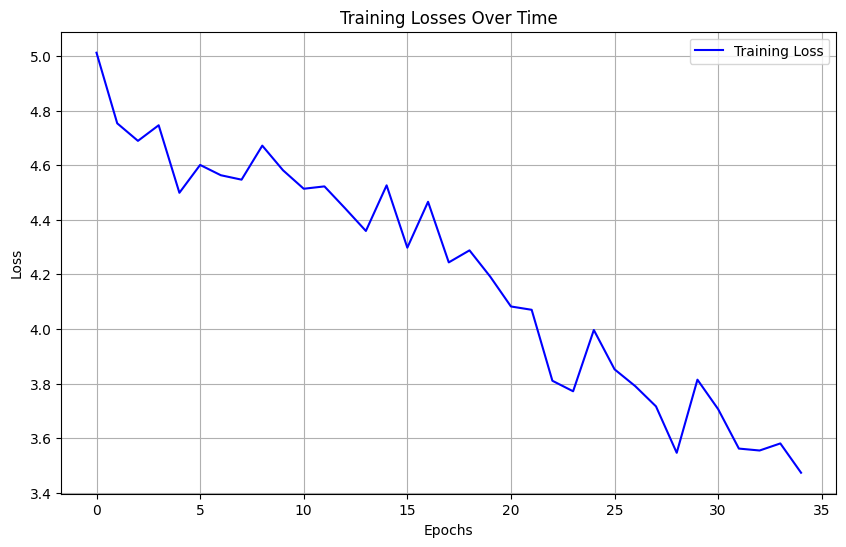

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
with open('train_losses.txt', 'r') as file:
    for line in file:
        train_losses.append(float(line.strip()))

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Time')
plt.legend()
plt.grid(True)
plt.show()


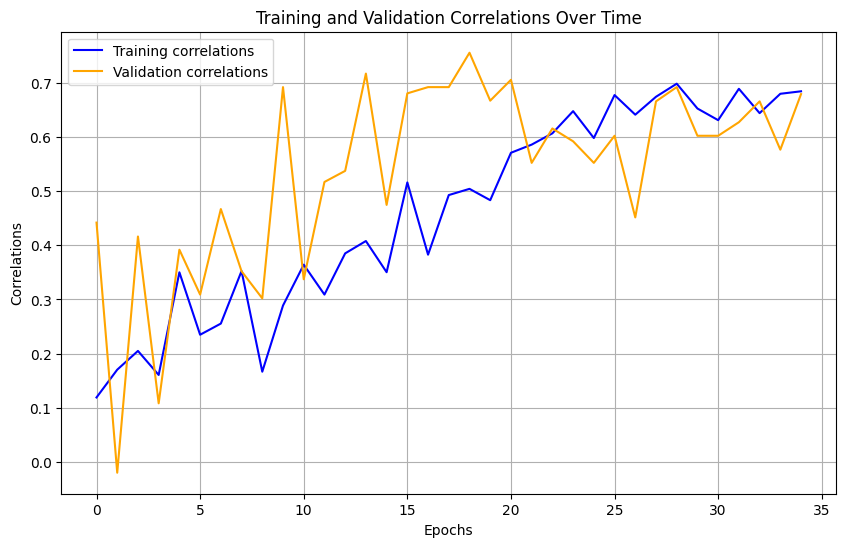

In [ ]:
train_correlations = []
with open('train_correlations.txt', 'r') as file:
    for line in file:
        train_correlations.append(float(line.strip()))

val_correlations = []
with open('val_correlations.txt', 'r') as file:
    for line in file:
        val_correlations.append(float(line.strip()))

plt.figure(figsize=(10, 6))
plt.plot(train_correlations, label='Training correlations', color='blue')
plt.plot(val_correlations, label='Validation correlations', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Correlations')
plt.title('Training and Validation Correlations Over Time')
plt.legend()
plt.grid(True)
plt.show()
